<style>
body {
        font-family: "Monaco", sans-serif;
}
</style> 
# Sherman lab RNAseq analysis pipeline
_by Tige Rustad
    Senior Scientist in the lab of David Sherman at SCRI
    Affiliate Assistant Professor in the UW Dept. of Global Health

## Why use a Jupyter notebook

 ***
 This version of the notebook is focused on presenting the data from a specific experiment I'll describe below. 
 I think I can make this more generally useful, a really Plug-n-Play RNAseq analysis pipeline that
 can take any log-normal distributed type of data and get a good first pass understanding of what the data tells you.
 Making that more generic tool will take more time, but if I seem to being doing things in a round-about fashion, 
 that may be why.
 
 Also, there are many good basic intros to Jupyter notebooks on YouTube, so I won't go through all that here. 
***
The purpose of this notebook is to walk through the analysis of RNAseq data from a hypoxic time course experiment I'll describe below. Initially this Jupyter notebook was a way for me to keep the code I used for analyzing this experiment along with notes to myself. Then realized I could share this with people in our lab, David in particular, who might get a lot of insight from reading a Jupyter style notebook. I think my notes are surprisingly readable and easy to generate in this format, and it lets you see my notes, the method used, shown in text boxes, and the resulting tables and figures all in a single narrative. More, you can try making changes to the code on the fly. 

Now I've decided to write this to a more general audience, with an eye toward making this more broadly useful.

I should be able to take this whole notebook and post it to myBinder.com so that anyone can use it without having to install _anything_ on their computer other than an internet browser. That is so cool. However if I can't get that to work I can still share this notebook with anyone who has Anaconda installed on their computer, so here are additional installation steps for users running this locally (instead of just looking at the contents on nbviewer or running it from myBinder.com).

You will need to to do the following steps:
1. Install the __[Anaconda python distribution](https://www.anaconda.com/distribution/)__. This will let you run all of the python scripts, pre-installs the most popular Python libraries, provides Jupyter notebook support, and, like BioConductor for R, is curated to maintain stability.
2. Install the Clustergrammer 'widget' so we can generate interactive heatmaps/dendograms.
    - First run the 'Anaconda prompt' to open a window where we can install new libraries
    - Then run the following commands:
        -  conda install -c conda-forge ipywidgets
        -  pip install --upgrade clustergrammer_widget
        -  jupyter nbextension enable --py --sys-prefix widgetsnbextension
        -  jupyter nbextension enable --py --sys-prefix clustergrammer_widget
3. The big one. This notebook is designed to be used with __[tidy datasets](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)__. That means each row is a different observation, in this case an RNAseq run, and each column is a different variable, here either the expression for a given gene or a column of metadata. 


This notebook was inspired by the excellent walkthrough of Seaborn plotting __[here](https://www.kaggle.com/mjbahmani/a-comprehensive-ml-workflow-with-python)__ and the __[Zika virus notebook](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4972086/)__ from the Ma'ayan lab, and when possible I simply borrowed code from those examples.  

## Experimental design

These data come from an experiment testing the transcriptional impact of perturbing specific transcription factors of _Mycobacerium tuberculosis_ (Mtb), specifically in the context of a hypoxic time course. Oxygen limitation is an environmental stress that arrests growth, alters the drug susceptibility profile, and leads to a complex remodeling of the transcriptome that changes the expression of the majority of the Mtb genes. Hypoxia, or oxygen limitation, is a common in vitro model of Mtb in the latent phase of infection. 

A prior screen of all of the Mtb transcription factors (TFs) by us identified six TFs that were impaired in their ability to return to active growth when oxygen is returned after 7 days of hypoxia. We have dubbed this set of TFs the Critical Oxygen Response Regulators, or CORRs. 

#### Simple description

 - Strains: Each strain is carrying the same TF overexpression plasmid with the only difference being the insert
    - Rv0023  - a previously undescribed TF that triggers many of the expression changes triggered by hypoxia when induced
    -  Rv0081  - part of the initial hypoxic response, regulon also has large overlap with hypoxic response
    -  Rv0353  - HspR, regulator of the heat shock protein chaperones
    -  Rv1985c - Several proposed functions for this TF, none confirmed yet, deleted in the vaccine strain BCG
    -  Rv2788  - SirR, suggested role as regulator of manganese homeostasis and other stress responses
    -  Rv3416  - WhiB3, redox homeostasis regulator, described in multiple papers from Adrie Steyn
    -  Empty   - This strain carrys the same plasmid as the others, but there is no TF inserted

 - Hypoxia: Each strain was taken through a hypoxic time course that begins with log phase growth to hypoxia and reaeration
    -  Log
    -  Hypoxia
    -  Reaeration

 - Time: After the day 0 sample is taken the culuture is transfered to a flask that has a steady flow of nitrogen with 0.2% oxygen, roughly 1% of atmospheric.
    -  Day 0  - Log phase culture
    -  Day 2  - Hypoxia
    -  Day 4  - Hypoxia
    -  Day 7  - Hypoxia. Culture transfered to aerobic rolling flask
    -  Day 8  - Reaeration
    -  Day 9  - Reaeration
    -  Day 10 - Reaeration
    -  Day 11 - Reaeration
    -  Day 12 - Reaeration. Not present for some strains


#### More detail for people with less background in TB research and our prior experiments

The strains used in this experiment were made as part of a previous project. They all come from the lab strain H37Rv, often abbreviated 'Rv', and each strain is carrying a plasmid that allows us to induce the overexpression of one of the CORRs. These plasmids have the TF gene downstream of a strong promoter and the TetO operator, which is recognized by the TetR repressor. In the presence of the inducer (anhydrotetracycline or Atc) TetR is removed from the promoter and these strains begin expressing that TF from the plasmid in addition to the native copy in the genome. These TFs have varying levels of baseline expression, but in all cases the given TF becomes one of the most highly expressed genes in the genome. 

Also note that these TFs have been modified so that they carry a FLAG tag on their C' tail. We don't haven't found an example where the tail has any impact on the TF function, but it is certainly possible that in some cases that extra bit will interfere or modify DNA binding properties. Note- the FLAG tag was used in ChIP experiments to determine the DNA binding profile of each TF.

Transcription factors typically change their promoter affinity based on some secondary signal like a small molecule, modifications to the TF by another protein (e.g. phosphorylation by a kinase), or interaction with a partner protein. In this case however we are driving activation of these TFs by mass action, simply overcoming the weak interaction of the TF without the activating signal by generating an excess of TF, some of which will bind to and activate that gene's regulon. 

Activation of TFs by overexpression could lead to binding and activation of genes not normally regulated by that TF. It's also possible that the the TF may have some impact on the cell other than DNA binding, and these effects could lead to changes in gene expression. 

## Setup

### Import python libraries and initialize global style settings. 

In [1]:
## import all required python libraries

from scipy.spatial.distance import euclidean, pdist, squareform
from sklearn.decomposition import PCA
from clustergrammer_widget import *
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import sklearn    # do I need?
import scipy      # do I need?
import numpy
import time
import json
import sys
import csv
import os

In [ ]:
## libraries not currently used in this notebook
## if I finish this and still don't need any of these this block can be removed

# from sklearn.metrics import make_scorer, accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn import preprocessing
# from pandas import get_dummies
# import xgboost as xgb
# import warnings

We also want to run a few commands to set the style for the following plots. There are many possible styles and palettes

In [2]:
## style settings for seaborn, pylab, and matplotlib
sns.set(style='white', context='notebook', palette='deep')
pylab.rcParams['figure.figsize'] = 12,8
mpl.style.use('ggplot')
sns.set_style('white')

## set so figures show up in the notebook just below the code block
%matplotlib inline

## limit output to 10 lines
pd.set_option('display.max_rows', 10)

# Import data
In the future I'd like to add the ability to start with raw FASTQ files straight from the sequencers, but that'll take time and I'd rather finish a working version of this notebook first, so we will start with data that has been processed to generate read counts for each gene.

We start by loading the RNAseq data into a pandas data frame. Remember that the data being imported __must__ be in 'tidy' format, which makes the importing part so smooth. The python library 'pandas' is is a very useful way of storing data in spreadsheet-like 'panel data', thus the name. Then we will break this table into a table with data and a table with metadata.

In [7]:
## import data from a csv file and use the first row as indices, or row names
df = pd.read_csv("./data/CORRtable.csv", index_col=0)

## use the name of the first column of data to find its index
FIRST_DATA_COL = df.columns.get_loc('Rv0001')

## Check the size and show a sample of the imported data
sample_num, obs_num = df.shape
print (f"This data set is comprised of {sample_num} RNAseq samples, each with {obs_num} variables")
df.iloc[:5,:8]

This data set is comprised of 186 RNAseq samples, each with 4033 variables


,Strain,Day,Oxygen,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005
EmptyPlasmid_D0_H5_R1,EmptyPlasmid,0,Log phase,334,182,148,172,1631
EmptyPlasmid_D0_H6_R2,EmptyPlasmid,0,Log phase,293,215,142,163,987
EmptyPlasmid_D0_H7_R3,EmptyPlasmid,0,Log phase,315,252,140,165,1087
EmptyPlasmid_D0_TC6_R1,EmptyPlasmid,0,Log phase,472,253,124,114,1194
EmptyPlasmid_D10_H5_R1,EmptyPlasmid,10,Reaearation,379,102,95,95,1120


***
The first three columns of data contain meta-information about these samples (Strain, Day, and Oxygen) and the remaining columns show the count of reads that align to the given gene per million reads total, or CPM.

Later on we will want to refer to just the data or just the metadata, so let's create those subtables.

In [75]:
## split the 'df' dataframe into data and metadata
data = df.iloc[:,FIRST_DATA_COL:]
meta = df.iloc[:,:FIRST_DATA_COL-1]

## take a look at the resulting tables to make sure they look right.
print ("Data table shape:",data.shape)
print ("Meta(data) table shape:",meta.shape)

meta.iloc[:10,:]

Data table shape: (186, 4030)
Meta(data) table shape: (186, 2)


,Strain,Day
EmptyPlasmid_D0_H5_R1,EmptyPlasmid,0
EmptyPlasmid_D0_H6_R2,EmptyPlasmid,0
EmptyPlasmid_D0_H7_R3,EmptyPlasmid,0
EmptyPlasmid_D0_TC6_R1,EmptyPlasmid,0
EmptyPlasmid_D10_H5_R1,EmptyPlasmid,10
EmptyPlasmid_D10_H6_R2,EmptyPlasmid,10
EmptyPlasmid_D10_H7_R3,EmptyPlasmid,10
EmptyPlasmid_D10_TC6_R1,EmptyPlasmid,10
EmptyPlasmid_D10_TC6_R3,EmptyPlasmid,10
EmptyPlasmid_D11_H5_R1,EmptyPlasmid,11


Now we want to inspect each column of metadata. We first create vectors containing each element of metadata for use as categories and set up a color palette for each. 

In [53]:
## let's make a function that plots a quick barplot showing each value and the color assigned to it
def paltest (values, test_pal):
    paltest = pd.DataFrame(index = values)
    paltest['test']=1
    plt.subplots(figsize = (1,len(values)))
    sns.barplot(y=paltest.index, x=paltest.test, palette = test_pal)

In [38]:
## create a list with the strain of each sample and a list with all unique strains
strains = df['Strain']
unique_strains = np.unique(strains)

## Now let's use an interactive color palette selector
print(f"You'll want to set the number of colors to _{len(unique_strains)}_ so that you have one color per unique value.")
strain_pal = sns.choose_colorbrewer_palette('q')

You'll want to set the number of colors to _7_ so that you have one color per unique value.


interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

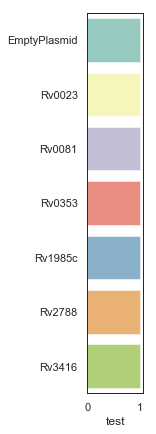

In [61]:
## once color map is selected, we make a 'look-up-table' that tells us what color to map to each value
## then make a table that has the color for each sample, based on the strain.
strain_lut = dict(zip(unique_strains, strain_pal))
strain_cols = pd.Series(strains).map(strain_lut)

paltest(unique_strains,strain_pal)

In [68]:
days = df['Day'].astype("str")
unique_days = np.unique(days)

## Now let's use an interactive color palette selector
print(f"You'll want to set the number of colors to _{len(unique_days)}_ so that you have one color per unique value.")

day_pal = sns.choose_colorbrewer_palette('q')

You'll want to set the number of colors to _9_ so that you have one color per unique value.


interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

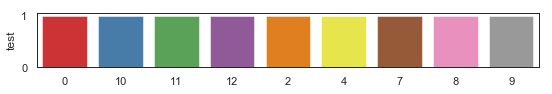

In [73]:
## once color map is selected, we make a 'look-up-table' that tells us what color to map to each value
## then make a table that has the color for each sample, based on the strain.
day_lut = dict(zip(unique_days, day_pal))
strain_cols = pd.Series(days).map(day_lut)


paltest = pd.DataFrame(index = unique_days)
paltest['test']=1
plt.subplots(figsize = (len(unique_days),1))
sns.barplot(x=paltest.index, y=paltest.test, palette = day_pal)

In [78]:
## Lastly lets pick out a color scheme for the heatmap
hmap_col = sns.choose_cubehelix_palette()

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

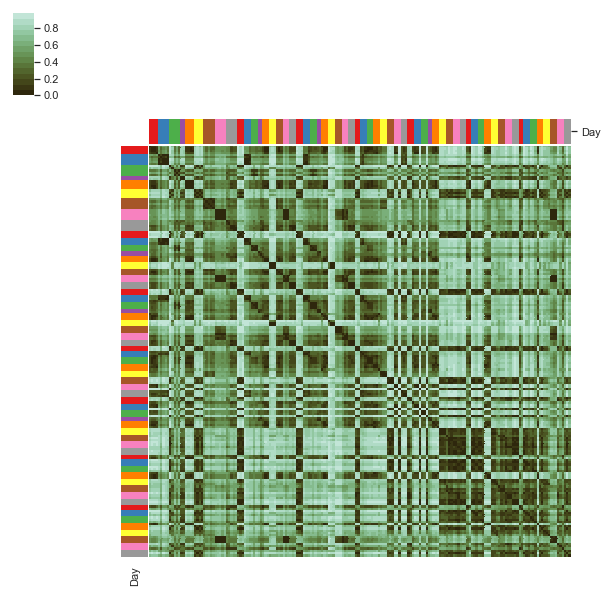

In [90]:
## generate the distance matrix 
dists = pdist(data, 'correlation')
col_ident_mat = pd.DataFrame(squareform(dists), index=df.index, columns=df.index)

colors = pd.DataFrame(strain_cols).merge(pd.DataFrame(day_cols))

g = sns.clustermap(col_ident_mat,
                   # Turn off the clustering
                   row_cluster=False, col_cluster=False,

                   # Add colored class labels
                   row_colors = day_cols,
                   col_colors = strain_cols,
                   # Make the plot look better when many rows/cols
                   linewidths=0, xticklabels=False, yticklabels=False,

                   # use the color scheme selected above for the heatmap
                   cmap = hmap_col
                  )
# Draw the legend bar for the classes                 
#for label in df['Day'].unique():
#    g.ax_col_dendrogram.bar(0, 0, color=day_lut[label],
#                            label=label, linewidth=0)

#l1 = g.ax_col_dendrogram.legend(title='Day', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.6))    


#for label in df['TC'].unique():
#    g.ax_row_dendrogram.bar(0, 0, color=tc_lut[label],
 #                           label=label, linewidth=0)

#l2 = g.ax_row_dendrogram.legend(title='TC', loc="right", ncol=2, bbox_to_anchor=(6, 1.2))
    
# Adjust the postion of the main colorbar for the heatmap
#g.cax.set_position([1, .2, .03, .45])


In [91]:

for i in range(len(unique_strains)):
    sset = df.loc[df['Strain']== unique_strains[i]]

    ## generate the distance matrix 
    ssdists = pdist(sset.iloc[:,4:], 'correlation')
    col_ident_mat = pd.DataFrame(squareform(ssdists), index=sset.index)

    ## set the label colors so we can see how well the samples cluster by day
    day_pal = sns.color_palette('husl', len(sset['Day'].unique()))
    day_lut = dict(zip(sset.Day.unique(), day_pal))
    day_cols = pd.Series(sset.Day).map(day_lut)
    cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
    #plt.figure()
    g = sns.clustermap(col_ident_mat,
                       # Turn off the clustering
                       row_cluster=False, col_cluster=False,

                       # Add colored class labels
                       row_colors = day_cols,                        
                       # Make the plot look better when many rows/cols
                       linewidths=0, xticklabels=False, yticklabels=True,

                       # use the color scheme selected above for the heatmap
                       cmap = colmap
                      )
    # Draw the legend bar for the classes                 
    for label in sset['Day'].unique():
        g.ax_col_dendrogram.bar(0, 0, color=day_lut[label],
                                label=label, linewidth=0)
    g.ax_col_dendrogram.legend(loc="center", ncol=3)
    g.ax_col_dendrogram.set_xlim([0,0])

    # Adjust the postion of the main colorbar for the heatmap
    g.cax.set_position([1.2, .2, .03, .45])
    g.ax_heatmap.set_title (unique_strains[i])


NameError: name 'strain' is not defined

Generally, the replicates look like each other, and the hypoxic time points generally stand out. Now let's collapse the replicates, and then convert to log base 2. Why do I do this? Expression data has a log-normal distribution, so it's simpler to plot and understand the data in a log scale. There is nothing magical about a two-fold difference of course, but in my experience even under the best of conditions with minimal noise changes less than two fold are rarely significant. So, having log base 2 means that we can easily see two fold steps in expression.

In [ ]:
logdata.loc[['EmptyPlasmid','Rv0023'],'Rv0023']

## Interactive heatmap - Clustergrammer

This tool by the Ma'ayan lab creates a heatmap that is amazingly easy to use. At least on my computer it has problems with looking at more than a dozen arrays at a time, so here I'll first collapse the replicates and then use Clustergrammer to look at the genes with the largest differences between samples. 

In [106]:
# convert df in Clustergrammer format
df2 = df.T
newlabs = df2.loc['Oxygen',:].add_prefix('Oxygen: ')
df2.loc['Oxygen',:]=newlabs
# check the size and type of the imported data
df2.head()

,EmptyPlasmid_D0_H5_R1,EmptyPlasmid_D0_H6_R2,EmptyPlasmid_D0_H7_R3,EmptyPlasmid_D0_TC6_R1,EmptyPlasmid_D10_H5_R1,EmptyPlasmid_D10_H6_R2,EmptyPlasmid_D10_H7_R3,EmptyPlasmid_D10_TC6_R1,EmptyPlasmid_D10_TC6_R3,EmptyPlasmid_D11_H5_R1,...,Rv3416_D4_TC6_R3,Rv3416_D7_TC6_R1,Rv3416_D7_TC6_R2,Rv3416_D7_TC6_R3,Rv3416_D8_TC6_R1,Rv3416_D8_TC6_R2,Rv3416_D8_TC6_R3,Rv3416_D9_TC6_R1,Rv3416_D9_TC6_R2,Rv3416_D9_TC6_R3
Strain,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,EmptyPlasmid,...,Rv3416,Rv3416,Rv3416,Rv3416,Rv3416,Rv3416,Rv3416,Rv3416,Rv3416,Rv3416
Day,0,0,0,0,10,10,10,10,10,11,...,4,7,7,7,8,8,8,9,9,9
Oxygen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rv0001,334,293,315,472,379,191,213,292,256,28,...,15,153,108,114,87,103,294,120,38,57
Rv0002,182,215,252,253,102,93,113,84,126,13,...,19,88,39,46,35,75,200,65,16,31


In [107]:
# instantiate a Network instance with the widget class as an argument
net = Network(clustergrammer_widget)

# import data into clustergrammer
net.load_file('./data/CORRtable2.txt')

# normalize values to z-scores (i.e. how many st dev from the mean)
net.normalize(axis='row', norm_type='zscore', keep_orig=True)

# cluster using default parameters
net.cluster()


In [95]:
net.filter_N_top('row', 20, 'sum')

In [108]:
# make interactive widget
net.widget()

clustergrammer_widget(network='{"row_nodes": [{"name": "Rv0001", "ini": 4030, "clust": 2954, "rank": 752, "ran…

In [109]:
## average replicates, convert to log base 2, and round to two significant digits
logdata = df.groupby(['Strain', 'Day']).mean()
logdata = np.log2(logdata)
logdata = np.round(logdata, decimals=2)

In [110]:
logdata.head()

Rv0001  Rv0002  Rv0003  Rv0004  Rv0005  Rv0006  Rv0007  \
Strain       Day                                                           
EmptyPlasmid 0      8.47    7.82    7.11    7.26   10.26    9.70    8.78   
             2      8.69    8.29    7.55    7.51   10.33    9.67    8.43   
             4      6.67    5.84    4.60    5.42    9.27    8.10    7.53   
             7      7.19    7.33    6.30    6.16    9.14    8.05    7.32   
             8      7.12    6.23    5.95    6.15    9.30    8.30    7.41   

                  Rv0008c  Rv0009  Rv0010c   ...     Rv3915  Rv3916c  Rv3917c  \
Strain       Day                             ...                                
EmptyPlasmid 0       6.23   10.04     9.37   ...       8.70     8.24     8.81   
             2       6.47   10.57     9.74   ...       8.81     8.29     8.55   
             4       6.29    7.55     6.92   ...       8.65     9.34     7.12   
             7       6.69    9.95     9.31   ...       8.81     8.98     7.83   
             8       7.04    9.18     8.57   ...       8.74     8.77     7.62   

                  Rv3918c  Rv3919c  Rv3920c  Rv3921c  Rv3922c  Rv3923c  \
Strain       Day                                                         
EmptyPlasmid 0       8.47     9.06    10.50    10.08    10.14    10.20   
             2       8.21     8.97    10.65    10.36    10.78    10.87   
             4       6.41     6.47     6.25     5.50     5.61     6.80   
             7       7.45     8.01     9.08     9.31    10.30    10.41   
             8       7.17     7.99     8.88     9.04    10.27    10.68   

                  Rv3924c  
Strain       Day           
EmptyPlasmid 0      10.15  
             2      10.85  
             4       7.62  
             7      10.24  
             8      11.00  

[5 rows x 4030 columns]

In [111]:
# First we will generate a PCA plot to collapse all of the gene expression values (dimensions) in a way that maximizes difference between samples


time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(logdata)
elapsed = time.time()-time_start
print ("PCA done! Time elapsed:",elapsed," seconds")

PCA done! Time elapsed: 0.07296967506408691  seconds


Now let's make a function to plot the data from PCA (and later tSNE) plots

In [ ]:
#fashion_scatter(top_two_comp.values,types)
colors = types
x = top_two_comp



palette.shape

In [ ]:
dir(net)

Now we collect the PCA data into a new data frame for plotting and calculate how much of the sample variance can be described by each component.

In [112]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ("Variance explained per principal component: ", pca.explained_variance_ratio_)

Variance explained per principal component:  [0.5959668  0.119129   0.05803857 0.047319  ]


In [ ]:
colors, cats = pd.factorize(types)

In [113]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

sns.scatterplot(x = pca_df['pca1'], y = pca_df['pca2'], hue = types, palette = palette) # Visualizing the PCA output

NameError: name 'palette' is not defined